# Import package 

In [1]:
#Quantum machine import 
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *
from configuration_spectrum_map import *

#General os library 
import os
import time
import sys


from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
u = unit()


#Path for HQCPC7 
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Drivers\Drivers') #path for the analysis function
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')


#Path for HQC PC15 
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Analysis_Function\NonLinearRes')
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Drivers')


from RohdeSchwartz import FSW
import AnFunc as an # analysis function
import imageio



from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from IPython.display import display
import scipy.io

# Octave & OPX configuration

In [45]:
#Octave & OPX configuration  
Saving_Path=r"X:\Users\beaulieu\Data\Run01\123\\"
Cooldown_Date="2023_05_05"

#Octave & OPX configuration 
opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53



#Mixers for the fluxline 
octave_output_gain=-10

octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave

qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)

#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)

2023-05-09 13:49:59,680 - qm - INFO - Performing health check
2023-05-09 13:49:59,692 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-05-09 13:49:59,692 - qm - INFO - Health check passed


In [3]:
def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""

    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_delay(delay,config,qmm):
    """ Update the input offsets of the qm in the configuration file """
    
    config["elements"]["fluxline"]["digitalInputs"]["switch"]["delay"]=delay
    
    
    qm=qmm.open_qm(config)
    
    return config, qm

def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["twoPhoton_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

# Spectrum Analyzer Setup

https://www.itu.int/en/ITU-D/Regional-Presence/ArabStates/Documents/events/2020/SM/Pres/S2D3Spectrum%20Analyzer.pdf

Reference level : is the top edge of the display and represents the maximum power expected at the spectrum analyzer input. Typically, we want ther reference level to be slighly above above our signal power. Setting the reference level too high or too low decrease the dynammic range. 

Input attenuator : When we set the reference level, the input attenuator is adjusted to have a proper gain and avoid overloading the isntrument

RBW: spectrum analyzer performs heterodyne measurement. The RBW sets the size of the IF filter before the detector. Can be understood as a filter sweeping on the signal. The RBW also affects the noise floor. Decreasing the RBW by a factor of 10 decreases the noise floor by a factor of 10 dBm. 

VBW : filter used to average or smooth out the displayed trace. Only affect how it is displayed and not acquired. The video bandwidth only reduces the noise on the trace. It doesn not lower the noise floor or imporve frequency resolution or signal separation. 

Typical spectrum parameters for device 104 are :
- centerSpan = True
- centerFreq = 4.3503e9 
- spanFreq = 500#1e6    
- pointsNum =501   
- RBW_bandwidth = 2
- VBW_bandwidth = 2
- level=0.5

Typical pulse 104 :
- length : 2_000_000_000 (2s)
- Delay : 50_000_000

Typical spectrum parameters for device 123 are :
- centerSpan = True
- centerFreq =4.33335e9 
- spanFreq = 10e3  
- pointsNum = 1001
- RBW_bandwidth = 10
- VBW_bandwidth = 10
- level=0.5

Typical pulse 123 :
- length : 600_000_000
- Delay : 5_000_000


In [8]:
sa =  FSW('TCPIP0::169.254.209.74::inst0::INSTR')

#Parameters of the spectrum analyzer 
centerSpan = True
centerFreq =(LO_fluxline+IF_fluxline)/2
spanFreq = 4e3  
pointsNum = 1001
RBW_bandwidth = 10
VBW_bandwidth =10  #10
level=0.5
noise_cancel=False
attenuation=0
range_spectrum=50

if centerSpan:
    startFreq = centerFreq - spanFreq/2
    stopFreq = centerFreq + spanFreq/2
    
sa.set_RBW(RBW_bandwidth) # set RBW bandwidth
sa.set_VBW(VBW_bandwidth) # set the VBW bandwidth 
sa.set_sweep(startFreq, stopFreq, pointsNum)  # set the sweep 
sa.set_trig(level) # sets the continuous trigger mode 
sa.set_input_coupling("AC")
sa.set_input_impedance(50)
sa.set_continuous("on")
sa.set_noise_correction(noise_cancel)
sa.set_attenuation(attenuation)
sa.set_display(0)
sa.set_range(range_spectrum)

## Testing the pump
Sets of programs for calibrating the pump at the frequency defined in the configuration file and also playing an infinite pulse to look at the spectrum Analyzer

In [5]:
#Calibration of the fluxline mixer 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

2023-05-09 12:35:59,226 - qm - INFO - Flags: 
2023-05-09 12:35:59,226 - qm - INFO - Compiling program
2023-05-09 12:36:01,844 - qm - INFO - Sending pre-compiled program to QOP


In [6]:
# Applies a continious pump for testing 
amp_factor=0.5

twoPhoton_len=500_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(amp_factor), 'fluxline')
           
job = qm.execute(TwoPhoton)

2023-05-09 12:36:20,366 - qm - INFO - Flags: 
2023-05-09 12:36:20,367 - qm - INFO - Sending program to QOP
2023-05-09 12:36:20,400 - qm - INFO - Executing program


In [7]:
job.halt()

True

## Testing of the pump and trigger
Program for testing the trigger with the pump. The program plays the pump pulse as defined in the configuation file. The pulse triggers the Analyzer and the spectrum can then be collected

In [45]:
(4.3288e9*2-8.6e9)/1e6

57.6

In [36]:
amp_factor=0.6
twoPhoton_len=2_000_000_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)
delay=400_000_000
config,qm=update_delay(delay,config,qmm)

with program() as TriggerTest:
    
    #update_frequency("fluxline",0.1e9) #fluxline offset 
    play("pumping"*amp(amp_factor), 'fluxline')
    
    
simulation = False
if simulation:
    simulation_config = SimulationConfig(
        duration=10000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    
    job = qmm.simulate(config, TriggerTest, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'3','4' },digital_ports={'1','3'})    
else:
    job = qm.execute(TriggerTest)
        

2023-05-08 20:50:23,745 - qm - INFO - Flags: 
2023-05-08 20:50:23,746 - qm - INFO - Sending program to QOP
2023-05-08 20:50:23,774 - qm - INFO - Executing program


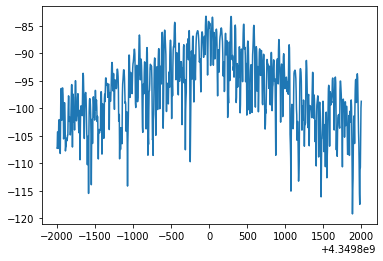

In [37]:
#Collects the data 
[freq, val] = sa.collect_spectrum()

plt.plot(freq, val)
plt.show()

## Testing for updating frequencies 

Porgramm for a single frequency with the trigger. This program sweeps the frequency of the pump and looks at the network analyzer where it is defined. The settings of the network analyzer are as defined in the cell above

In [17]:
%%time

amp_factor=0.6
twoPhoton_len=2_000_000_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)
delay=400_000_000
config,qm=update_delay(twoPhoton_len,config,qmm)
waiting_acquisition_time=0.2

# Frequency sweep 
span=10 * u.kHz # Span of the pumping 
df = 1 * u.kHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies

Data=np.zeros((2,pointsNum))

#defines the program 
with program() as MultiTriggerTest:
    
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    

    with for_(*from_array(f,freqs)):

        update_frequency("fluxline",f) # updates the IF frequency to the array 
        play("pumping"*amp(amp_factor), 'fluxline') #Plays the pump pulse on the flux line 
        pause() # pause to collect the data from the trigger 

           
job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    
for j in range(len(freqs)):
    while not job.is_paused():
        time.sleep(0.001)
    
    #Data is collected here in a 3d matrix. Each page of the 3D matrix correspond to a 2 d matrix 
    # with two rows. One row being the frequency and the other being the signal 
    
    #time.sleep(pointsNum/RBW_bandwidth**2) #time delay for the acquisition 
    print(j/len(freqs))
    time.sleep(waiting_acquisition_time)
    
    [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
    
    Analyzer_value=Analyzer_value.transpose()
    Analyzer_freq=Analyzer_freq.reshape(1,Analyzer_freq.shape[0])
    single_trace=np.vstack([Analyzer_value, Analyzer_freq])
    Data=np.dstack((Data,single_trace)) # Stacks all of the 2D matrix into a 3D matrix 

    job.resume()  # Resume to the program

    
 

2023-05-01 15:54:58,123 - qm - INFO - Flags: 
2023-05-01 15:54:58,123 - qm - INFO - Sending program to QOP
2023-05-01 15:54:58,160 - qm - INFO - Executing program
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
Wall time: 22.7 s


In [18]:
%matplotlib qt

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,0.9, 0.9])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("IF pulse frequency", fontsize=14)

ax.pcolormesh(Data[1,:,1],freqs,Data[0,:,1:].transpose(),cmap= "viridis",shading="auto")

ax.plot((freqs+LO_fluxline)/2,freqs,'r',marker=".",linestyle = 'None') #points that we are looking at for the half of the pump 

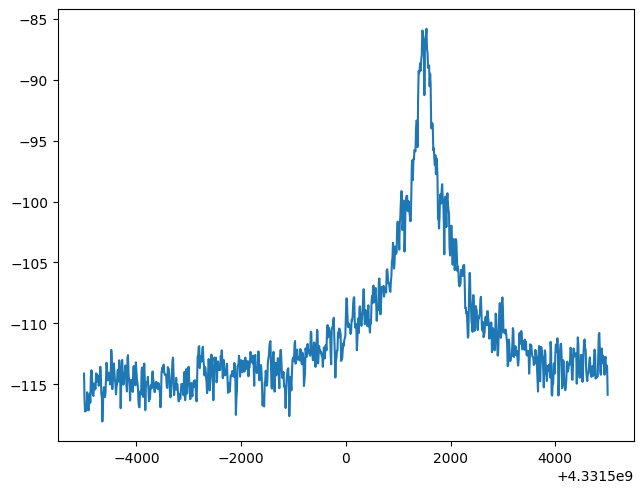

In [55]:
%matplotlib inline
fig=plt.figure()
idx=9
ax=fig.add_axes([0.1, 0.1 ,0.9, 0.9])
ax.plot(Data[1,:,idx],Data[0,:,idx])

## Set the Parameters 
Section to set the QM parameters for all the sucessive measurements

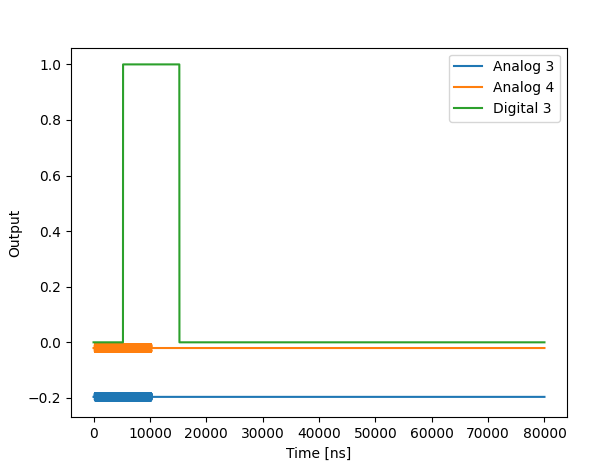

In [9]:
twoPhoton_len=600_000_000   #2_000_000_000 #600_000_000   #600_000_000 #Lenght of the pulse 
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)
delay=50_000_000  #5_000_000 #delay time before sending the trigger once the pulse has been sent
config,qm=update_delay(delay,config,qmm)
waiting_acquisition_time=0.2

In [41]:
%matplotlib qt
# Simulation 

twoPhoton_len=10000 #Lenght of the pulse 
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)
delay=50000 #delay time before sending the trigger once the pulse has been sent
config,qm=update_delay(delay,config,qmm)
waiting_acquisition_time=0.2

#single frequency 
IF_center=190e6
freqs = np.array([IF_center]) #sets of frequencies

with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()

    play("pumping"*amp(0.1), 'fluxline') #Plays the pump pulse on the flux line 


        
            
simulation = True

if simulation:
    simulation_config = SimulationConfig(
        duration=20000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, MultiTriggerTest, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'3','4' },digital_ports={'1','3'})
        
        

2023-04-19 16:09:47,605 - qm - INFO - Flags: 
2023-04-19 16:09:47,606 - qm - INFO - Simulating program


# Display Parameter 

In [10]:

print("LO of fluxline: {} GHz".format(config['elements']['fluxline']["mixInputs"]["lo_frequency"]/1e9))
print("IF of fluxline : {} GHz".format(config['elements']['fluxline']['intermediate_frequency']/1e9))
print("Fluxline pulse time : {} ns".format(config["pulses"]["twoPhoton"]["length"]))
print("Fluxline amplitude : {} V".format(config["waveforms"]["twoPhoton_wf"]['sample']))

LO of fluxline: 8.6 GHz
IF of fluxline : 0.0576 GHz
Fluxline pulse time : 600000000 ns
Fluxline amplitude : 0.125 V


# Full Measurement Code for a single 2D Map 
For each pump amplitude, the frequency of the pump is swept and we collect the traces with the spectrum Analayzer

In [13]:
save_trace=False
cooldown_date=Cooldown_Date #top folder 
device="Spectrum" #second folder 
name="Map" # third folder 
meastype="filename" #Final file name 


#Pump frequency sweep 
span=1 * u.MHz # Span of the pumping 
df = 0.01 * u.MHz # Step of the pumping 0.01
IF_center=0.1978e9
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies

#Amplitude sweep
a_min = 0.3
a_max = 0.7
da = 0.05#0.005
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


#Number of average
Number_Average=2

NumberPoints=freqs.shape[0]*amplitudes.shape[0]
TimePerPoint=(4*60)/210
print("There will be {} points".format(NumberPoints))
print("The total tim for 1 average is {} min".format(NumberPoints*TimePerPoint/60))
print("The total time for all averages is {} min".format(NumberPoints*TimePerPoint*Number_Average/60))


There will be 900 points
The total tim for 1 average is 17.142857142857142 min
The total time for all averages is 34.285714285714285 min


In [14]:
%%time
datadict={}
datadict["Analyzer_center_freq"]=centerFreq
datadict["Analyzer_span"]=spanFreq
datadict["Numpoints"]=pointsNum
datadict["RBW_bandwidth"]=RBW_bandwidth
datadict["VBW_bandwidth"]=VBW_bandwidth
datadict["amplitudes"]=amplitudes  
datadict["octave_gain"]=octave_output_gain
datadict["Pump_freq"]=freqs+LO_fluxline
datadict["configuration"]=config
datadict["Data"]={}

Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
    with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
        
        with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

            update_frequency("fluxline",f) # updates the IF frequency to the array 
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    
for k in range(len(amplitudes)):
    
    #Data where each row is a pump frequency (3d matrix to be compatible with following)
    Data=np.zeros((len(freqs),pointsNum,1)) 
    
    print(k/len(amplitudes))

    for j in range(len(freqs)):

        while not job.is_paused():
            time.sleep(0.001)

        time.sleep(waiting_acquisition_time) #time delay for the acquisition 

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Analyzer_freq_all[j,:]=Analyzer_freq
        Data[j,:,0]=Analyzer_value.transpose()
       
        #Here the center frequency of the next measurement is set
        if j<(len(freqs)-1):
            sa.set_center_freq((freqs[j+1]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
            time.sleep(0.2)
        else:
            sa.set_center_freq((freqs[0]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
            time.sleep(0.2)
            
        job.resume()  # Resume to the program
                  
    #Collect the Data matrix for saving 
    datadict["Data"][amplitudes[k]]=Data
                  
#only collect one of the full analyzer frequency matrix because it is always the same 
datadict["Analyzer_freq"]=Analyzer_freq_all 
    
#If save trace is on 
if save_trace:
     an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\\")

2023-04-19 12:00:12,561 - qm - INFO - Flags: 
2023-04-19 12:00:12,562 - qm - INFO - Sending program to QOP
2023-04-19 12:00:12,802 - qm - INFO - Executing program
0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888
Wall time: 15min 40s


## Save and load Data

In [ ]:
#Save datadict  
cooldown_date=Cooldown_Date #top folder 
device="Spectrum" #second folder 
name="Map" # third folder 
meastype="filename" #Final file name 

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)  

In [66]:
#Loading the data 

filepath=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\Spectrum\Map\Map_test.npz"

npzfile=np.load(filepath,allow_pickle=True)
#npzfile["multidata"][()]

amplitudes=npzfile["multidata"][()]["amplitudes"]
Data=npzfile["multidata"][()]["Data"]
Pump_freq=npzfile["multidata"][()]["Pump_freq"]
Analyzer_freq=npzfile["multidata"][()]["Analyzer_freq"]

In [15]:
#If the Data was not saved, we change variables for doing a quick analysis  
Data=datadict["Data"]
Pump_freq=datadict["Pump_freq"]
Analyzer_freq=datadict["Analyzer_freq"]
amplitudes=datadict["amplitudes"]

## Analysis of a single map

(<Figure size 708.661x472.441 with 2 Axes>,
 <Axes:title={'center':'Map_test'}, xlabel='Pump Frequency [GHz]', ylabel='Amplitudes (*125V)'>,
 <matplotlib.colorbar.Colorbar at 0x2d507ca9848>)

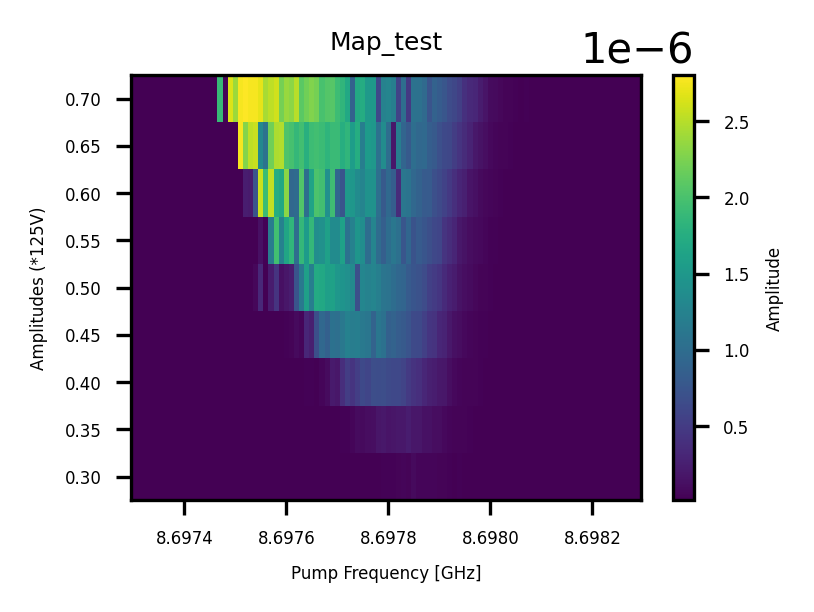

In [16]:
#Integrate all of the amplitudes 
integrate=an.average_trace_numpy(Data,amplitudes,Pump_freq,Analyzer_freq)

an.plot2D(Pump_freq/1e9,amplitudes,integrate,labels=["Pump Frequency [GHz]","Amplitudes (*125V)","Amplitude"],title=meastype, figsize=(6/2.54, 4/2.54),colormap = "viridis", vmin=None, vmax=None, dpi=300, fontsize=4,reversed=False)

# Full measumerent code with averages of the 2D map

This allows performing the measurement code N times and each time saving a new matrix data to be averaged later. 
It takes the parameters defined in the in the blocks before 

In [31]:
8.5e9+0.129840e9

8629840000.0

In [17]:
%%time

datadict={}
datadict["Analyzer_center_freq"]=centerFreq
datadict["Analyzer_span"]=spanFreq
datadict["Numpoints"]=pointsNum
datadict["RBW_bandwidth"]=RBW_bandwidth
datadict["VBW_bandwidth"]=VBW_bandwidth
datadict["amplitudes"]=amplitudes  
datadict["octave_gain"]=octave_output_gain
datadict["Pump_freq"]=freqs+LO_fluxline
datadict["configuration"]=config
datadict["Data"]={}
datadict["octave_gain"]=octave_output_gain

        
Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
        
        with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

            update_frequency("fluxline",f) # updates the IF frequency to the array 
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           
# Each measurement, we get the full map 
for i in range(0,Number_Average,1) : 
    
    job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    #Data where each row is a pump frequency (3d matrix to be compatible with following). Initialized for each average
    Data=np.zeros((len(freqs),pointsNum,1)) #
    
    for k in range(len(amplitudes)):

        print(k/len(amplitudes))

        for j in range(len(freqs)):


            while not job.is_paused():
                time.sleep(0.001)


            time.sleep(waiting_acquisition_time) #time delay for the acquisition 

            [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 

            Analyzer_freq_all[j,:]=Analyzer_freq
            Data[j,:,0]=Analyzer_value.transpose()

            #Here the center frequency of the next measurement is set
            if j<(len(freqs)-1):
                sa.set_center_freq((freqs[j+1]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
                time.sleep(0.2)
            else:
                sa.set_center_freq((freqs[0]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
                time.sleep(0.2)
            job.resume()  # Resume to the program

  
        #concatenate the data of same amplitude for each average 
        if i>0:
            datadict["Data"][amplitudes[k]]=np.concatenate((datadict["Data"][amplitudes[k]],Data),axis=2)
        else:     
            datadict["Data"][amplitudes[k]]=Data
                  
#only collect one of the full analyzer frequency matrix because it is always the same 
datadict["Analyzer_freq"]=Analyzer_freq_all 
    
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other)

2023-04-19 12:37:55,074 - qm - INFO - Flags: 
2023-04-19 12:37:55,075 - qm - INFO - Sending program to QOP
2023-04-19 12:37:55,110 - qm - INFO - Executing program
0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888
2023-04-19 12:53:33,605 - qm - INFO - Flags: 
2023-04-19 12:53:33,606 - qm - INFO - Sending program to QOP
2023-04-19 12:53:33,648 - qm - INFO - Executing program
0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777778
0.8888888888888888
Wall time: 31min 17s


## Save and load Data

In [ ]:
#Save datadict  
cooldown_date=Cooldown_Date #top folder 
device="Spectrum_av" #second folder 
name="Map" # third folder 
meastype="filename" #Final file name 

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)  

In [ ]:
#Loading the data 

filepath=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\Spectrum\Map\Map_test.npz"

npzfile=np.load(filepath,allow_pickle=True)
#npzfile["multidata"][()]

amplitudes=npzfile["multidata"][()]["amplitudes"]
Data=npzfile["multidata"][()]["Data"]
Pump_freq=npzfile["multidata"][()]["Pump_freq"]
Analyzer_freq=npzfile["multidata"][()]["Analyzer_freq"]

In [18]:
#If the Data was not saved, we change variables for doing a quick analysis  
Data=datadict["Data"]
Pump_freq=datadict["Pump_freq"]
Analyzer_freq=datadict["Analyzer_freq"]
amplitudes=datadict["amplitudes"]

## Analysis of a single map

(<Figure size 708.661x472.441 with 2 Axes>,
 <Axes:title={'center':'Map_test'}, xlabel='Pump Frequency [GHz]', ylabel='Amplitudes (*125V)'>,
 <matplotlib.colorbar.Colorbar at 0x2d507d9d408>)

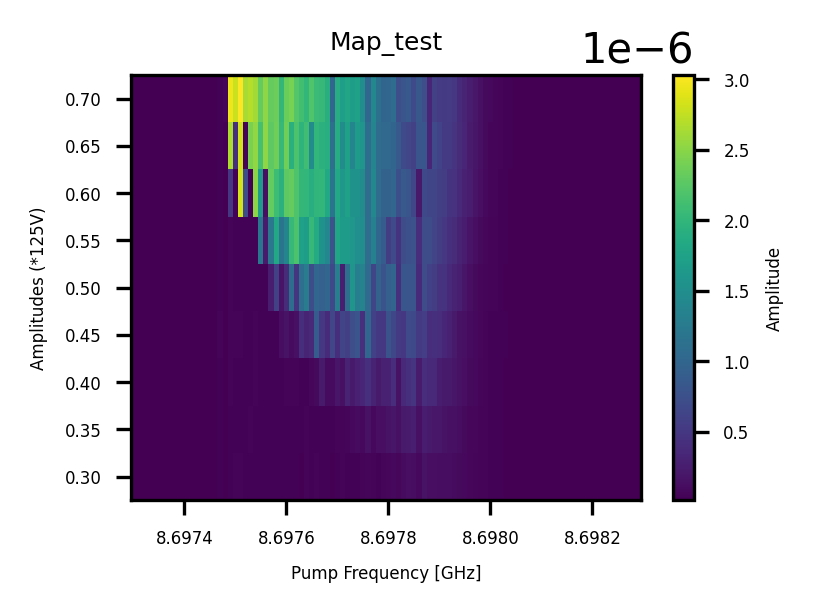

In [19]:
integrate=an.average_trace_numpy(Data,amplitudes,Pump_freq,Analyzer_freq)

an.plot2D(Pump_freq/1e9,amplitudes,integrate,labels=["Pump Frequency [GHz]","Amplitudes (*125V)","Amplitude"],title=meastype, figsize=(6/2.54, 4/2.54),colormap = "viridis", vmin=None, vmax=None, dpi=300, fontsize=4,reversed=False)

# Measurement of amplitude cuts 

This allows the measurement of a single amplitude cut, n times to get an average

In [11]:
span=1 * u.MHz # Span of the pumping 
df = 0.02 * u.MHz # Step of the pumping 0.01
IF_center=57.6e6   #0.1296e9
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies
print(freqs)


[57100000. 57120000. 57140000. 57160000. 57180000. 57200000. 57220000.
 57240000. 57260000. 57280000. 57300000. 57320000. 57340000. 57360000.
 57380000. 57400000. 57420000. 57440000. 57460000. 57480000. 57500000.
 57520000. 57540000. 57560000. 57580000. 57600000. 57620000. 57640000.
 57660000. 57680000. 57700000. 57720000. 57740000. 57760000. 57780000.
 57800000. 57820000. 57840000. 57860000. 57880000. 57900000. 57920000.
 57940000. 57960000. 57980000. 58000000. 58020000. 58040000. 58060000.
 58080000.]


In [38]:
save_trace=False
#Saving parameters 
cooldown_date=Cooldown_Date #top folder 
device="Spectrum_av" #second folder 
name="Amplitude_cut" # third folder 
meastype="Multiple_amp_2000ms" #Final file name 

#Amplitude for the sweep
amplitudes = [0.7]



# a_max=0.65
# amplitudes=np.geomspace(a_min, a_max, 10, endpoint = True)f

#Number of average
n_avg = 40

#Expected time 
NumberPoints=freqs.shape[0]*len(amplitudes)
TimePerPoint=(23.5*60)/1350
print("The number of points (without average) :{}".format(NumberPoints))
print("The expected time without the average :{}".format(NumberPoints*TimePerPoint/60))
print("The total expected time (with average) :{}".format(NumberPoints*TimePerPoint*n_avg/60))

The number of points (without average) :50
The expected time without the average :0.8703703703703705
The total expected time (with average) :34.81481481481482


In [39]:
%%time

datadict={}
datadict["Analyzer_center_freq"]=centerFreq
datadict["Analyzer_span"]=spanFreq
datadict["Numpoints"]=pointsNum
datadict["RBW_bandwidth"]=RBW_bandwidth
datadict["octave_gain"]=octave_output_gain
datadict["VBW_bandwidth"]=VBW_bandwidth
datadict["amplitudes"]=np.array(amplitudes)  #convert list to numpy array to be save for all measurements
datadict["Pump_freq"]=freqs+LO_fluxline
datadict["n_avg"]=n_avg
datadict["octave_gain"]=octave_output_gain
datadict["configuration"]=config
datadict["Data"]={}

Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
    with for_each_(a, amplitudes): # for all the amplitudes 

        with for_(n, 0, n < n_avg, n + 1):  # Notice it's < a_max + da/2 to include a_max

            with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

                update_frequency("fluxline",f) # updates the IF frequency to the array 

                play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

                pause() # pause to collect the data from the trigger 
 
    job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    
#During job on pause     
for l in range(len(amplitudes)):
    
    Data=np.zeros((len(freqs),pointsNum,n_avg)) #data in the format of rows corresponding to each measurement and column from the spectrum analyzer and we get one for each iteration to average       
    
    for k in range(n_avg):

        print(k/n_avg)

        for j in range(len(freqs)):

            while not job.is_paused():
                time.sleep(0.001)


            time.sleep(waiting_acquisition_time) #time delay for the acquisition 

            [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 

            Analyzer_freq_all[j,:]=Analyzer_freq #Collect the Analyzer frequency 
            Data[j,:,k]=Analyzer_value.transpose() #Collect the data where each row is a pump frequency and column is an analyzer frequency 

            #Here the center frequency of the next measurement is set
            if j<(len(freqs)-1):
                sa.set_center_freq((freqs[j+1]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
                time.sleep(0.2)
            else:
                sa.set_center_freq((freqs[0]+LO_fluxline)/2) #sets the new center frequency on the spectrum analyzer 
                time.sleep(0.2)
            job.resume()  # Resume to the program

    
    #Collect the Data matrix for saving 
    datadict["Data"][amplitudes[l]]=Data

    
#only collect one of the full analyzer frequency matrix because it is always the same 
datadict["Analyzer_freq"]=Analyzer_freq_all 
    
#save if save_trace is on 
if save_trace:
    an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)  
    
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other)

2023-05-09 13:10:47,529 - qm - INFO - Flags: 
2023-05-09 13:10:47,530 - qm - INFO - Sending program to QOP
2023-05-09 13:10:47,582 - qm - INFO - Executing program
0.0
0.025
0.05
0.075
0.1
0.125
0.15
0.175
0.2
0.225
0.25
0.275
0.3
0.325
0.35
0.375
0.4
0.425
0.45
0.475
0.5
0.525
0.55
0.575
0.6
0.625
0.65
0.675
0.7
0.725
0.75
0.775
0.8
0.825
0.85
0.875
0.9
0.925
0.95
0.975
Wall time: 34min 47s


## Save and load data 

In [46]:
#Save datadict  
cooldown_date=Cooldown_Date #top folder 
device="Spectrum" #second folder 
name="Amplitude_cut" # third folder 
meastype="pi4_single_0p7_amp_600ms" #Final file name 

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)  

saving in new directory


In [3]:
#Loading the data 

filepath=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\Spectrum\Amplitude_cut\Initial_multi_amp_trace.npz"

npzfile=np.load(filepath,allow_pickle=True)
#npzfile["multidata"][()]

amplitudes=npzfile["multidata"][()]["amplitudes"]
Data=npzfile["multidata"][()]["Data"]
Pump_freq=npzfile["multidata"][()]["Pump_freq"]
Analyzer_freq=npzfile["multidata"][()]["Analyzer_freq"]

In [40]:
#If the Data was not saved, we change variables for doing a quick analysis  
Data=datadict["Data"]
Pump_freq=datadict["Pump_freq"]
Analyzer_freq=datadict["Analyzer_freq"]
amplitudes=datadict["amplitudes"]

## Analisys of single ampltiude cuts

In [41]:
#Integrate 
integrate=an.average_trace_numpy(Data,amplitudes,Pump_freq,Analyzer_freq)

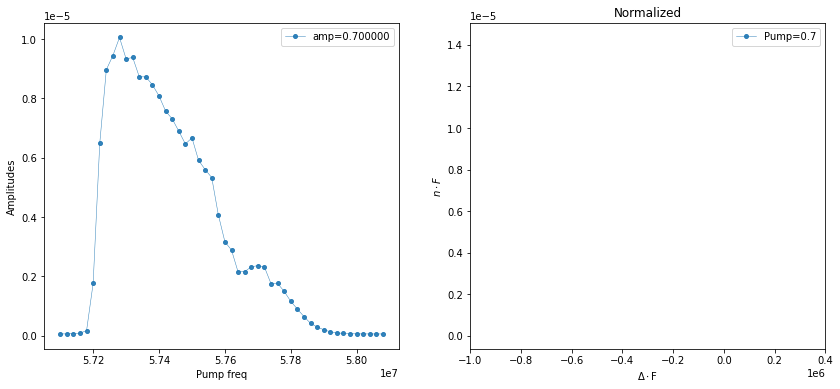

In [42]:
#Plotting the amplitude cuts and the renormalized data

fig, axs = plt.subplots( ncols=2, figsize=(14,6))
ax=axs[0]

for i in range(len(amplitudes)):
     ax.plot(freqs,integrate[i,:],'.-',label=f'amp={amplitudes[i]:1f}', alpha=.9, lw=.5, ms=8)
ax.set_xlabel("Pump freq")
ax.set_ylabel("Amplitudes")
ax.legend()

ax=axs[1]
Gi=1
center_freq=4.34980e9*2  

for i in range(len(amplitudes)):
    Gx=amplitudes[i]
    ax.plot((Pump_freq-center_freq)*Gi/Gx,integrate[i,:]*Gi/Gx, '.-',  label=f'Pump={amplitudes[i]:.1f}', alpha=.9, lw=.5, ms=8)

ax.set_title("Normalized")
ax.set_xlabel('$\Delta\cdot$F')
ax.set_ylabel('$n\cdot F$')
ax.set_xlim((-10e5,4e5))
ax.legend()

In [43]:
integrate=an.average_trace_numpy_after(Data,amplitudes,Pump_freq,Analyzer_freq)

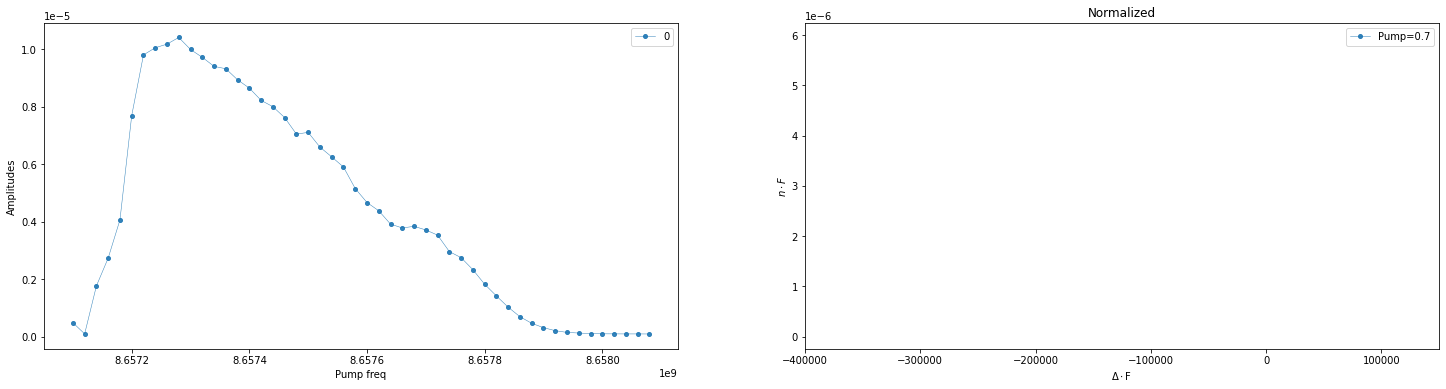

In [44]:
fig, axs = plt.subplots( ncols=2, figsize=(25,6))
ax=axs[0]

for i in range(len(amplitudes)):

    ax.plot(Pump_freq,np.mean(integrate[:,:,i],axis=0),'.-', alpha=.9, lw=.5, ms=8,label=i)
    ax.set_xlabel("Pump freq")
    ax.set_ylabel("Amplitudes")
ax.legend()


ax=axs[1]
Gi=0.4
center_freq=4.34975e9*2  


for i in range(len(amplitudes)):
    Gx=amplitudes[i]
    ax.plot((Pump_freq-center_freq)*Gi/Gx,np.mean(integrate[:,:,i],axis=0)*Gi/Gx, '.-',  label=f'Pump={amplitudes[i]:.1f}', alpha=.9, lw=.5, ms=8)

ax.set_title("Normalized")
ax.set_xlabel('$\Delta\cdot$F')
ax.set_ylabel('$n\cdot F$')
ax.set_xlim((-4e5,1.5e5))
ax.legend()

In [30]:
integrate.shape

(10, 50, 1)

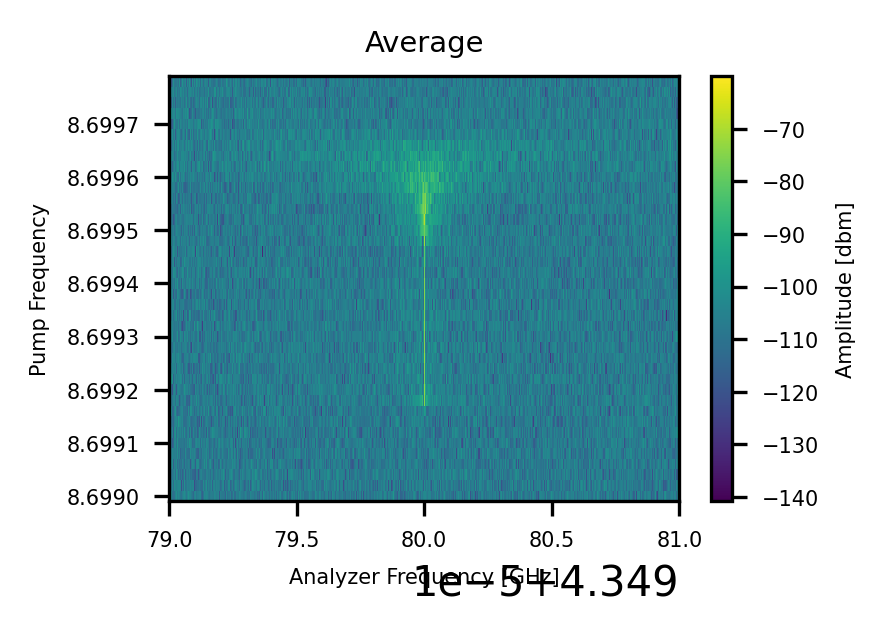

In [54]:
# plot the averaged 2d map of a given amplitudes  
ampli=amplitudes[0]
fig, ax, cbar=an.plot2D(Analyzer_freq[0,:]/1e9,Pump_freq/1e9,np.mean(Data[ampli],axis=2),labels=["Analyzer Frequency [GHz]","Pump Frequency","Amplitude [dbm]"],title="Average", figsize=(6/2.54, 4/2.54),colormap = "viridis", vmin=None, vmax=None, dpi=300, fontsize=5,reversed=False)

In [51]:
Data.shape

(8, 1001, 2)

# Sweeping Test

In [51]:
%matplotlib qt

freq = np.arange(100e6, 200e6, 10e6).astype(int)

twoPhoton_len=1000  #2_000_000 #Lenght of the pulse 
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

delay=0 #delay time before sending the trigger once the pulse has been sent
config,qm=update_delay(delay,config,qmm)


with program() as hello_qua:
    i = declare(int) 
    j = declare(int)
    f = declare(int, value=freq)

    with for_(i, 0, i < len(freqs), i + 1):
        
        with for_(j, 0, j <= i, j + 1):
            
            update_frequency("fluxline", f[j])
            
            play("pumping"*amp(amp_factor), 'fluxline')
            
simulation = True 

if simulation:
    simulation_config = SimulationConfig(
        duration=20000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, hello_qua, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'3','4' },digital_ports={'1','3'})

2023-04-20 14:34:25,751 - qm - INFO - Flags: 
2023-04-20 14:34:25,751 - qm - INFO - Simulating program


In [33]:
#Sweeping of the pump 
%matplotlib qt
twoPhoton_len=1000  #2_000_000 #Lenght of the pulse 
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

delay=0 #delay time before sending the trigger once the pulse has been sent
config,qm=update_delay(delay,config,qmm)

span=1 * u.MHz # Span of the pumping 
df = 0.2 * u.MHz # Step of the pumping 0.01
IF_center=0.1978e9
IF_center_1=0.1977e9
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies

amp_factor=0.4 
max_rep=20


#Will need to create a new pulse to avoid triggering the spectrum analyzer 
with program() as Test_pump_sweep:

    n = declare(int)
    i = declare(int)
    f = declare(int) # frequency 
  
    update_frequency("fluxline",IF_center) # updates the IF frequency to the array 
    with for_(i, 0, i < max_rep, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
        play("pumping"*amp(amp_factor), 'fluxline') #Plays the pump pulse on the flux line 
        
        with switch_(i):
            with case_(10):
                update_frequency("fluxline",IF_center_1)

        
simulation = True 

if simulation:
    simulation_config = SimulationConfig(
        duration=20000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, Test_pump_sweep, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'3','4' },digital_ports={'1','3'})
    
else :
    
    job = qm.execute(Test_pump_sweep) 
    
          

2023-04-19 15:41:50,461 - qm - INFO - Flags: 
2023-04-19 15:41:50,462 - qm - INFO - Simulating program


In [44]:
%matplotlib qt
twoPhoton_len=1000  #2_000_000 #Lenght of the pulse 
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

delay=0 #delay time before sending the trigger once the pulse has been sent
config,qm=update_delay(delay,config,qmm)

span=1 * u.MHz # Span of the pumping 
df = 0.2 * u.MHz # Step of the pumping 0.01
IF_center=0.1978e9
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies

amp_factor=0.4 
max_rep=20


with program() as Test_pump_sweep:

    f = declare(int) 
  
    with for_(*from_array(f,freqs)): 
        update_frequency("fluxline",f) 
        play("pumping"*amp(amp_factor), 'fluxline')
        
        
        
simulation = True 

if simulation:
    simulation_config = SimulationConfig(
        duration=20000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, Test_pump_sweep, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'3','4' },digital_ports={'1','3'})
    
else :
    
    job = qm.execute(Test_pump_sweep) 

2023-04-19 15:56:40,772 - qm - INFO - Flags: 
2023-04-19 15:56:40,773 - qm - INFO - Simulating program


# Other

## Program sweeping pump frequency and amplitude

The program here sweeps the amplitude of the pump. For each pump amplitude, the frequency is then sweep. 


In [ ]:
       
# # Frequency sweep 
# span=1 * u.MHz # Span of the pumping 
# df = 0.01 * u.MHz # Step of the pumping 
# freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies


# Frequency sweep 
span=10 * u.kHz # Span of the pumping 
df = 1 * u.kHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies

#Amplitude sweep
a_min = 0
a_max = 0.3
da = 0.1
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


Data=np.zeros((len(freqs),pointsNum,len(amplitudes))) #data 


#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
        
        with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

            update_frequency("fluxline",f) # updates the IF frequency to the array 
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           


job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    


for k in range(len(amplitudes)):
    
    print(k/len(amplitudes))
    
    
    
    for j in range(len(freqs)):


        while not job.is_paused():
            time.sleep(0.001)

       

        #time.sleep(pointsNum/RBW_bandwidth**2) #time delay for the acquisition 
        time.sleep(0.1) 

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Data[j,:,k]=Analyzer_value.transpose()
       

        job.resume()  # Resume to the program
        
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other)

In [ ]:
%matplotlib inline
#np.zeros((len(freqs),len(freqs),len(freqs)))

idx=3

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,0.9, 0.9])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("Amplitude", fontsize=14)


ax.pcolormesh(Analyzer_freq,freqs,Data[:,:,idx],cmap= "viridis",shading="auto")
#ax.plot(freqs+LO_fluxline,freqs,'r',marker=".",linestyle = 'None')

## Program sweeping pump frequency and amplitude

The program here sweeps the frequency of the pump and for each frequency. For each pump frequency, the amplitude is then sweep. 

In [ ]:
%%time
# Same program that sweeps the frequency of the pump source.But now also sweeps the amplitude. 

# Frequency sweep 
span=10 * u.kHz # Span of the pumping 
df = 2 * u.kHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies

#Amplitude sweep
a_min = 0.0
a_max = 0.5
da = 0.1
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


Data=np.zeros((len(amplitudes),pointsNum,len(freqs))) #data 


#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(*from_array(f,freqs)):
        
        update_frequency("fluxline",f) # updates the IF frequency to the array 
        
        with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max

            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           


job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    

for k in range(len(freqs)):
    
    print(k/len(freqs))
    
    
    
    for j in range(len(amplitudes)):


        while not job.is_paused():
            time.sleep(0.001)

       

        #time.sleep(pointsNum/RBW_bandwidth**2) #time delay for the acquisition 
        time.sleep(0.6)

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Data[j,:,k]=Analyzer_value.transpose()
       

        job.resume()  # Resume to the program
        
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other). Each 2d Matrix is for a given frequency of the pump 


In [ ]:
%matplotlib inline
#np.zeros((len(freqs),len(freqs),len(freqs)))

idx=5

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,0.9, 0.9])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("Amplitude", fontsize=14)

ax.pcolormesh(Analyzer_freq,amplitudes,Data[:,:,idx],cmap= "viridis",shading="auto")
#ax.plot(freqs+LO_fluxline,freqs,'r',marker=".",linestyle = 'None')

## Full measumrent with sweeping the amplitude 

In [210]:


# Pumping frequency sweep (around the IF+LO that is set in the configuration file)
span=1 * u.MHz # Span of the pumping 
df = 0.1 * u.MHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies


#Analyzer parameter

sa =  FSW('TCPIP0::169.254.209.74::inst0::INSTR')

### Tunable parameters
centerSpan = True
spanFreq = 0.1e6    
pointsNum = 1001
RBW_bandwidth = 100
VBW_bandwidth = 100
level=0.5 #trigger level 
    
sa.set_RBW(RBW_bandwidth) # set RBW bandwidth
sa.set_VBW(VBW_bandwidth) # set the VBW bandwidth 
sa.set_center_freq(freqs[0]+LO_fluxline) #First sets the first center frequency based on first frequnecy of sweep
sa.set_span(spanFreq) #set the frequency span 

sa.set_center_freq_up_mode(0.1e6)

sa.set_trig(level) # sets the continuous trigger mode 
sa.set_input_coupling("AC")
sa.set_input_impedance(50)
sa.set_continuous("on")
sa.set_display(0)


#Amplitude sweep
a_min = 0
a_max = 0.3
da = 0.1
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


Data=np.zeros((len(amplitudes),pointsNum,len(freqs))) #data in the format of rows corresponding to all pumping frequencies 
                         
                            # Column to all the points at the analyzer and third dimensions for each amplitude
        
Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max
        
        update_frequency("fluxline",f) # updates the IF frequency to the array 
        
        with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           


job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    


for k in range(len(freqs)):
    
    print(k/len(freqs))
    
    if k>0:
        Analyzer_freq_all[k,:]=Analyzer_value.transpose()
   
      
    for j in range(len(amplitudes)):


        while not job.is_paused():
            time.sleep(0.001)

        

        time.sleep(pointsNum/RBW_bandwidth**2) #time delay for the acquisition 

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Data[j,:,k]=Analyzer_value.transpose()
       
        #Here the center frequency of the next measurement is set
 
        job.resume()  # Resume to the program
   

    if k>0:
        time.sleep(0.5)
        sa.set_center_freq(freqs[k]+LO_fluxline) #sets the new center frequency on the spectrum analyzer 
        time.sleep(0.5)
    else:
        time.sleep(0.5)
        sa.set_center_freq(freqs[0]+LO_fluxline) #sets the new center frequency on the spectrum analyzer 
        time.sleep(0.5)


2023-02-23 19:44:11,142 - qm - INFO - Flags: 
2023-02-23 19:44:11,142 - qm - INFO - Sending program to QOP
2023-02-23 19:44:11,173 - qm - INFO - Executing program
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


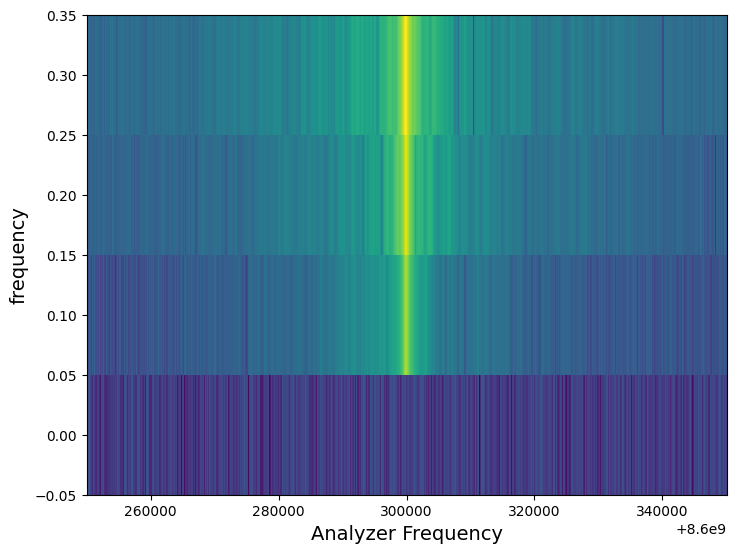

In [215]:
%matplotlib inline
#np.zeros((len(freqs),len(freqs),len(freqs)))

idx=0

fig= plt.figure()
ax=fig.add_axes([0.1, 0.1 ,1, 1])

ax.set_xlabel("Analyzer Frequency", fontsize=14)
ax.set_ylabel("frequency", fontsize=14)


ax.pcolormesh(Analyzer_freq,amplitudes,Data[:,:,idx],cmap= "viridis",shading="auto")
#ax.plot(freqs+LO_fluxline,freqs,'r',marker=".",linestyle = 'None')

In [209]:
#Measurement process : check if the delay for acquisition is actually sufficently long given your setup 
# Setup the autocalibration and the config file 
#Then, set the parameters and measure -> should probably calculate the number of points that make sense given your RBW 

array([[-1.18308884e+02, -1.19411766e+02, -1.18252663e+02, ...,
         9.90999953e+37,  9.90999953e+37,  9.90999953e+37],
       [-1.21270088e+02, -1.20495392e+02, -1.18441376e+02, ...,
        -1.18088547e+02, -1.14885170e+02, -1.17073578e+02],
       [-1.21322716e+02, -1.16610374e+02, -1.18893578e+02, ...,
        -1.16122261e+02, -1.19471100e+02, -1.19081093e+02],
       [-1.16607559e+02, -1.17442352e+02, -1.17747765e+02, ...,
        -1.17871376e+02, -1.15722717e+02, -1.18256935e+02]])

## Comment : you cannot select a bandwidth too small for some reason 

Two things to consider : when you lower the bandwidth of the analyzer, the pulse duration might finish before you have collected all the data at the Analyzer. Therefore, you might want to increase the pulse duration  

In [261]:
len(amplitudes)

31

In [ ]:
#OLD measurement code 

# Pumping frequency sweep (around the IF+LO that is set in the configuration file)
# span=1 * u.MHz # Span of the pumping 
# df = 0.05 * u.MHz # Step of the pumping 
# freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies


# Frequency sweep 
span=10 * u.kHz # Span of the pumping 
df = 2 * u.kHz # Step of the pumping 
freqs = np.arange(IF_fluxline-span/2, IF_fluxline+span/2, df) #sets of frequencies



#Analyzer parameter

sa =  FSW('TCPIP0::169.254.209.74::inst0::INSTR')

### Tunable parameters
# centerSpan = True
# spanFreq = 0.1e6    
# pointsNum = 1001
# RBW_bandwidth = 50
# VBW_bandwidth = 50
# level=0.5 #trigger level 
# waiting_acquisition_time=pointsNum/RBW_bandwidth**2
    
# sa.set_RBW(RBW_bandwidth) # set RBW bandwidth
# sa.set_VBW(VBW_bandwidth) # set the VBW bandwidth 
# sa.set_center_freq(freqs[0]+LO_fluxline) #First sets the first center frequency based on first frequnecy of sweep
# sa.set_span(spanFreq) #set the frequency span 

# sa.set_center_freq_up_mode(0.1e6)

# sa.set_trig(level) # sets the continuous trigger mode 
# sa.set_input_coupling("AC")
# sa.set_input_impedance(50)
# sa.set_continuous("on")
# sa.set_display(0)


#Amplitude sweep
a_min = 0
a_max = 0.3
da = 0.05
amplitudes = np.arange(a_min, a_max + da / 2, da)  # +da/2 to add a_max to the scan (vector of amplitudes)


Data=np.zeros((len(freqs),pointsNum,len(amplitudes))) #data in the format of rows corresponding to all pumping frequencies 
                         
                            # Column to all the points at the analyzer and third dimensions for each amplitude
        
Analyzer_freq_all=np.zeros((len(freqs),pointsNum)) #sets of all frequencies used at the analyzer

#defines the program 
with program() as MultiTriggerTest:
    
    a = declare(fixed)  # pump amplitude 
    f = declare(int) # frequency 
    n = declare(int) #iteration index
    n_st = declare_stream()
    
   
    with for_(a, a_min, a < a_max + da / 2, a + da):  # Notice it's < a_max + da/2 to include a_max
        
        with for_(*from_array(f,freqs)):  # Notice it's < a_max + da/2 to include a_max

            update_frequency("fluxline",f) # updates the IF frequency to the array 
            
            play("pumping"*amp(a), 'fluxline') #Plays the pump pulse on the flux line 

            pause() # pause to collect the data from the trigger 

           


job = qm.execute(MultiTriggerTest)  # Execute QUA program  

    


for k in range(len(amplitudes)):
    
    print(k/len(amplitudes))

    
    for j in range(len(freqs)):


        while not job.is_paused():
            time.sleep(0.001)

        

        time.sleep(waiting_acquisition_time) #time delay for the acquisition 

        [Analyzer_freq, Analyzer_value] = sa.collect_spectrum() # Collect the spectrum 
        
        Analyzer_freq_all[j,:]=Analyzer_freq
        Data[j,:,k]=Analyzer_value.transpose()
       
        
        #Here the center frequency of the next measurement is set
        if j<(len(freqs)-1):
            sa.set_center_freq(freqs[j+1]+LO_fluxline) #sets the new center frequency on the spectrum analyzer 
            time.sleep(0.05)
        else:
            sa.set_center_freq(freqs[0]+LO_fluxline) #sets the new center frequency on the spectrum analyzer 
            time.sleep(0.05)
        job.resume()  # Resume to the program
    

    
 #Data structure is a 3d matrix (set of 2d matrix stacked on top of each other)
